# <center>This `.ipynb` file contains the code for showing the autoencoder output</center>

### 1. Import the required libraries

In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.utils import make_grid

import os
import random
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

from pfiles.vqvae import VQVAE

### 2. Define the device

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device is:', device)

device is: cuda


### 3. Load the dataset

In [3]:
dir_src = '/project/dsc-is/nono/Documents/kpc/dat0'
data_src = 'slice128_Block2_11K.npy'

print(os.path.join(dir_src, data_src))

kpc_dataset = np.load(os.path.join(dir_src, data_src))
kpc_dataset = kpc_dataset[:, 0, :, :, :]

print(kpc_dataset.shape)
N_SAMPLE, HEIGHT, WIDTH, CHANNELS = kpc_dataset.shape

/project/dsc-is/nono/Documents/kpc/dat0/slice128_Block2_11K.npy
(11000, 128, 128, 3)


In [4]:
index_range = np.arange(N_SAMPLE)
split = np.array_split(index_range, 11)
test_dataset = split[10]
training_dataset = np.setdiff1d(index_range, test_dataset)

In [5]:
print('Length of the training dataset:', len(training_dataset))
print('Length of the test dataset:', len(test_dataset))

Length of the training dataset: 10000
Length of the test dataset: 1000


### 4. Custom functions for extracting batches of samples from the dataset

In [6]:
def make_batch_list(idx, n_batch=10, batch_size=None, shuffle=True):
    if shuffle:
        np.random.shuffle(idx)
    if batch_size is not None:
        n_batch = len(idx) // batch_size
    batch_list = np.array_split(idx, n_batch)
    return batch_list

In [7]:
transform = transforms.ToTensor()

def generate_batch(idx, kpc_dataset):
    tmp = []
    for i in idx:
        xxx = transform(kpc_dataset[i])
        tmp.append(xxx)
    xxx_batch = torch.stack(tmp, dim=0)
    return xxx_batch

### 5. Set up directory for saving models

In [8]:
task_name = 'kpc_ldm'

if not os.path.exists(task_name):
    os.mkdir(task_name)

### 6. Prepare to show the results

In [9]:
rgb_input = 3

model = VQVAE(im_channels=rgb_input).to(device)
model.eval()

model.load_state_dict(torch.load(os.path.join(task_name, 'vqvae_autoencoder_ckpt.pth'), map_location=device, weights_only=True))

<All keys matched successfully>

### 7. Autoencoder output

In [10]:
batch_list = make_batch_list(test_dataset, batch_size=50, shuffle=False)
im = generate_batch(batch_list[0], kpc_dataset).to(device)

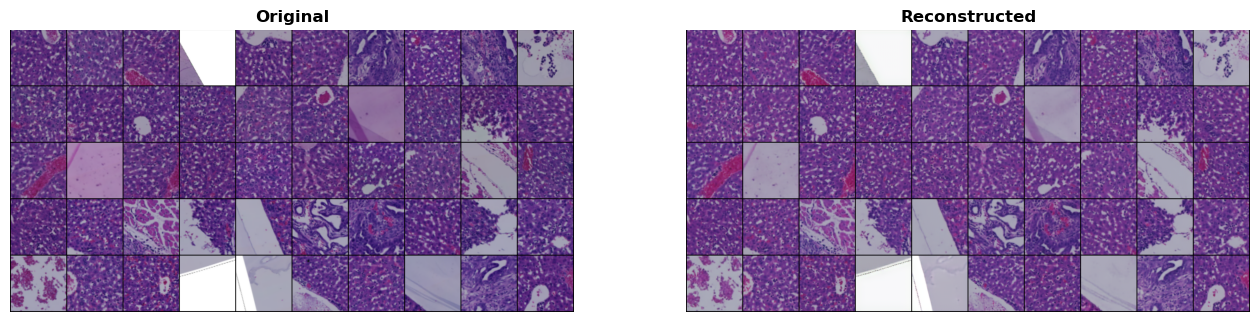

In [11]:
model.eval()
model_output = model(im)
output, z, quantize_losses = model_output

sample_size = 50
save_output = torch.clamp(output[:sample_size], 0., 1.).detach().cpu()
save_input = (im[:sample_size]).detach().cpu()

im_grid = make_grid(save_input, nrow=10)
out_grid = make_grid(save_output, nrow=10)
plt.figure(figsize=(16, 13))
plt.subplot(1, 2, 1)
plt.imshow(im_grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Original', fontweight='bold')
plt.subplot(1, 2, 2)
plt.imshow(out_grid.permute(1, 2, 0))
plt.axis(False)
plt.title('Reconstructed', fontweight='bold');